In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
#
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import os

In [53]:
df = pd.read_excel('C:/Users/82106/Desktop/코드 리뷰/data/Online Retail.xlsx')

In [54]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Processing

In [55]:
display(df.describe())

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


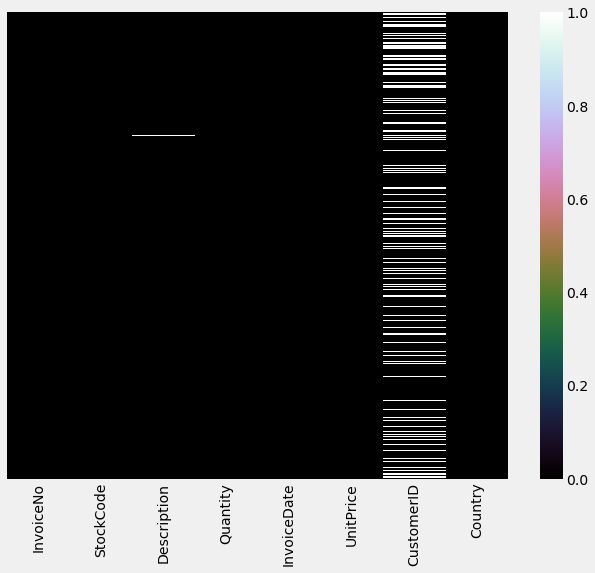

In [56]:
# 결측치 시각화
plt.subplots(figsize=(10,8))
sns.heatmap(df.isnull(),yticklabels=False, cmap='cubehelix') 
plt.show()

In [57]:
df.drop_duplicates(inplace=True)
df= df[(df['Quantity']>0) & (df['UnitPrice']>0) & (df['CustomerID'].notnull())]

In [58]:
df.shape

(392692, 8)

# Cohort Analsis

In [59]:
def get_month(x): return dt.datetime(x.year, x.month,1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

In [60]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [61]:
invoice_year, invoice_month, invoice_day = get_date_int(df, 'InvoiceDate')
cohort_year, cohort_month, cohort_day = get_date_int(df,'CohortMonth')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
df['CohortIndex'] = years_diff * 12 + months_diff + 1
df.tail()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01,5
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01,5
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01,5
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01,5
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01,5


In [62]:
# CohortMonth와 CohortIndex를 기준으로 데이터를 그룹화
grouping = df.groupby(['CohortMonth','CohortIndex'])

# 각 그룹별 고유한 CustomerID 수를 계산
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

# 인덱스를 리셋하여 데이터프레임 형태로 변환
cohort_data = cohort_data.reset_index()

# CohortMonth를 인덱스로, CohortIndex를 컬럼으로 하는 피벗 테이블 생성
cohort_counts = cohort_data.pivot(index = 'CohortMonth',
                                  columns = 'CohortIndex', 
                                  values = 'CustomerID')

In [63]:
# 각 코호트의 첫 달 고객 수를 추출
cohort_sizes = cohort_counts.iloc[:,0]

# 각 셀의 값을 해당 코호트의 첫 달 고객 수로 나누어 비율 계산
retention = cohort_counts.divide(cohort_sizes, axis=0)

# 인덱스를 날짜 형식으로 변환
retention.index = retention.index.date

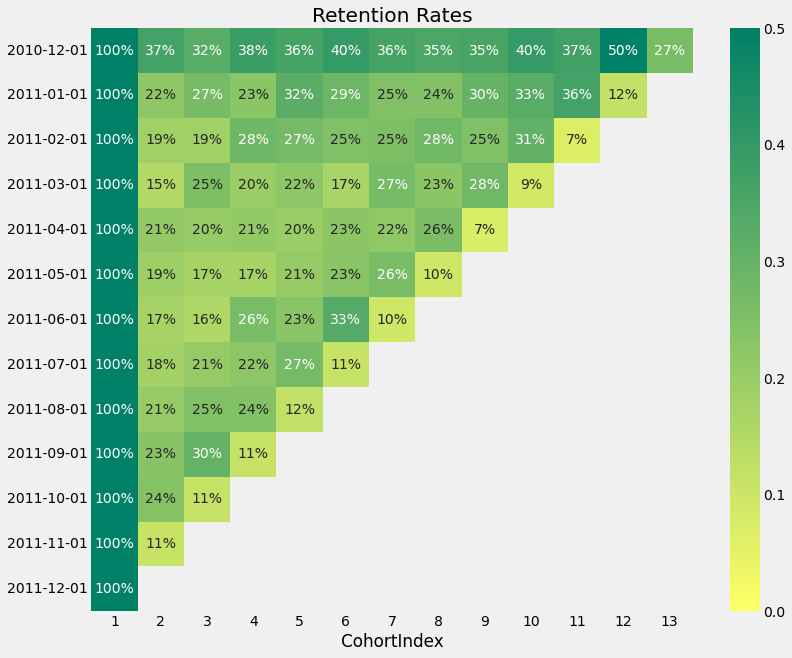

In [64]:
#sns.set()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,10))
plt.title('Retention Rates')

sns.heatmap(data= retention,
            annot = True,
            fmt = '.0%',
            vmin = 0.0,
            vmax = 0.5,
            cmap = 'summer_r')

plt.show()


# Customer segmentation with RFM

In [65]:
print(df.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'InvoiceMonth', 'CohortMonth',
       'CohortIndex'],
      dtype='object')


In [66]:
# Invoiceday 의 시간정보를 제외하고 날짜만 추출하여 Invoceday 칼럼 생성
df['InvoiceDay'] = df['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, x.day))

#데이터셋의 마지막 거래일 다음날을 기준일로 설정 (RFM 분석을 위한 기준점)
act_date = max(df['InvoiceDay'] + dt.timedelta(1))

# 총 구매 금액을 계산하여 TotalSum 컬럼 생성
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

In [67]:
#코호트 분석에서 사용했던 컬럼들을 제거 (RFM 분석을 위한 데이터 정리)
df.drop(['CohortMonth', 'InvoiceMonth', 'CohortIndex'], axis=1, inplace=True)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [68]:
#고객아이디별로 그룹화하여 RFM 지표 계산
rfm = df.groupby('CustomerID').agg({
    #마지막 구매일로 부터 현재까지의 경과일수
    'InvoiceDate' : lambda x: (act_date - x.max()).days,
    # 총구매횟수
    'InvoiceNo' : 'count',
    #총 구매금액의 합
    'TotalSum' : 'sum'
})

#칼럼명을 RFM 분석에 맞게 변경
rfm.rename(columns = {'InvoiceDate' : 'Recency',
                      'InvoiceNo' : 'Frequency',
                      'TotalSum' : 'MonetaryValue'}, inplace = True)

rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


In [69]:
#Recency 점수화
r_labels =range(3,0,-1)
r_groups = pd.qcut(rfm.Recency, q=3, labels=r_labels)

#Frequency 점수화
f_labels = range(1,4)
f_groups= pd.qcut(rfm.Frequency, q=3, labels=f_labels)

#Monetary 점수화
m_labels = range(1,4)
m_groups= pd.qcut(rfm.MonetaryValue, q=3, labels=m_labels)

In [70]:
# R, F, M 각각의 점수를 rfm 데이터프레임에 추가
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

# assign 메서드를 사용하여 더 알맞게 점수 할당
rfm = rfm.assign(R=r_groups, F=f_groups, M=m_groups)

# RFM 세그먼트 생성 : 각 점수를 문자열로 연결
rfm['RFM_Segment'] = rfm.apply(lambda x : str(x['R']) + str(x['F']) + str(x['M']), axis = 1)

# RFM 총점 계산 : R, F, M 점수의 합
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

#RFM 총점 계산
rfm['RFM_Score']  = rfm[['R','F','M']].sum(axis=1)

In [71]:
# RFM_Score 별로 그룹화하여 주요 지표들의 평균과 고개수 계산
rfm_agg = rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',          # 최근성의 평균
    'Frequency': 'mean',        # 구매빈도의 평균
    'MonetaryValue': ['mean', 'count']  # 구매금액의 평균과 고객 수
})

#칼럼명을 보기 좋게 변경
rfm_agg.rename(columns={
    'mean': 'Mean',     # 평균
    'count': 'Count'    # 고객 수
}, inplace=True)

rfm_agg.round(2)

Recency Frequency MonetaryValue      
             Mean      Mean          Mean Count
RFM_Score                                      
3          237.43     10.65        200.64   636
4          137.24     19.12        313.35   561
5          110.18     28.92        775.18   704
6           66.22     47.19        829.17   621
7           48.35     73.61       1625.29   558
8           33.81    139.14       2737.48   564
9            9.54    296.80       7308.82   694

In [72]:
# 고객등급 레이블 정의
score_labels = ['Bronze', 'Silver', 'Gold']

# RFM_SCORE를 3등분하여 각 구간에 등급 할당
score_groups = pd.qcut(rfm.RFM_Score,
                       q=3,
                       labels = score_labels)

#계산된 등급을 새로운 칼럼 'Robust RFM Level' 에 추가
rfm['Robust RFM Level'] = score_groups.values

In [73]:
rfm.describe()

,Recency,Frequency,MonetaryValue,RFM_Score
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.059474,90.523744,2048.688081,6.007838
std,100.012264,225.506968,8985.230220,2.021999
min,0.000000,1.000000,3.750000,3.000000
25%,17.000000,17.000000,306.482500,4.000000
50%,50.000000,41.000000,668.570000,6.000000
75%,141.750000,98.000000,1660.597500,8.000000
max,373.000000,7676.000000,280206.020000,9.000000
